# Graph approach

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [6]:
data = pd.read_csv('data/soil_climate_data.csv')

In [7]:
# drop rows with missing values
data = data.dropna()

# drop rows with is_dry = 1
data = data[data['is_dry'] == 0]

In [8]:
# drop columns year and is_dry
data = data.drop(columns=['year', 'is_dry'])

In [9]:
data.reset_index(drop=True, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42626 entries, 0 to 42625
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   soil_ph_b0                42626 non-null  float64
 1   soil_ph_b10               42626 non-null  float64
 2   soil_ph_b100              42626 non-null  float64
 3   soil_ph_b200              42626 non-null  float64
 4   soil_ph_b30               42626 non-null  float64
 5   soil_ph_b60               42626 non-null  float64
 6   soil_carbon_b0            42626 non-null  float64
 7   soil_carbon_b10           42626 non-null  float64
 8   soil_carbon_b100          42626 non-null  float64
 9   soil_carbon_b200          42626 non-null  float64
 10  soil_carbon_b30           42626 non-null  float64
 11  soil_carbon_b60           42626 non-null  float64
 12  soil_sand_b0              42626 non-null  float64
 13  soil_sand_b10             42626 non-null  float64
 14  soil_s

In [7]:
import networkx as nx
from geopy.distance import geodesic
import pandas as pd
import tqdm

# Create a graph
well_net = nx.Graph()

# Add nodes (well locations)
for i in tqdm.tqdm(range(data.shape[0]), desc='Adding nodes'):
    well_net.add_node(i, pos=(data['Lat'][i], data['Lon'][i]))
    # Add relevant node attributes explicitly
    for col in ['Lat', 'Lon', 'DepthToWater_m']:  # Add only relevant columns
        well_net.nodes[i][col] = data[col][i]

Adding nodes: 100%|██████████| 42626/42626 [00:01<00:00, 38874.61it/s]


In [12]:
import networkx as nx
from scipy.spatial import KDTree
from geopy.distance import geodesic
import pandas as pd
import tqdm

# Function to compute edges for a batch of nodes
def compute_edges_for_batch(start_idx, end_idx, tree, data, threshold_km):
    edges = []
    for i in range(start_idx, end_idx):
        # Query neighbors within the threshold
        neighbors = tree.query_ball_point((data['Lat'][i], data['Lon'][i]), threshold_km / 111)  # Approx degrees
        for j in neighbors:
            if i < j:  # Avoid duplicate edges
                distance = geodesic((data['Lat'][i], data['Lon'][i]), (data['Lat'][j], data['Lon'][j])).kilometers
                if distance < threshold_km:
                    edges.append((i, j, distance))
    return edges

# Build the KDTree
coords = data[['Lat', 'Lon']].values
tree = KDTree(coords)

# Threshold in kilometers
threshold_km = 5

# Split work into chunks for parallel processing
from concurrent.futures import ThreadPoolExecutor
batch_size = 1000
num_batches = (data.shape[0] + batch_size - 1) // batch_size

edges = []
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(
            compute_edges_for_batch, 
            i * batch_size, 
            min((i + 1) * batch_size, data.shape[0]), 
            tree, 
            data, 
            threshold_km
        )
        for i in range(num_batches)
    ]
    for future in tqdm.tqdm(futures, desc="Computing edges"):
        edges.extend(future.result())

# Add edges
well_net.add_weighted_edges_from(edges)

Computing edges: 100%|██████████| 43/43 [08:49<00:00, 12.31s/it]


In [16]:
data.columns

Index(['soil_ph_b0', 'soil_ph_b10', 'soil_ph_b100', 'soil_ph_b200',
       'soil_ph_b30', 'soil_ph_b60', 'soil_carbon_b0', 'soil_carbon_b10',
       'soil_carbon_b100', 'soil_carbon_b200', 'soil_carbon_b30',
       'soil_carbon_b60', 'soil_sand_b0', 'soil_sand_b10', 'soil_sand_b100',
       'soil_sand_b200', 'soil_sand_b30', 'soil_sand_b60', 'soil_silt_b0',
       'soil_silt_b10', 'soil_silt_b100', 'soil_silt_b200', 'soil_silt_b30',
       'soil_silt_b60', 'soil_clay_b0', 'soil_clay_b10', 'soil_clay_b100',
       'soil_clay_b200', 'soil_clay_b30', 'soil_clay_b60',
       'climate_conditions_ppt', 'climate_conditions_tmean', 'Lat', 'Lon',
       'DepthToWater_m'],
      dtype='object')

In [17]:
# add node attributes
for i in tqdm.tqdm(range(data.shape[0]), desc='Adding node attributes'):
    for col in data.columns:
        well_net.nodes[i][col] = data[col][i]

Adding node attributes: 100%|██████████| 42626/42626 [00:07<00:00, 5702.42it/s]


In [18]:
import pickle

# save graph
with open('bins/well_network.gpickle', 'wb') as f:
    pickle.dump(well_net, f)

In [1]:
import pickle

# import graph
with open('bins/well_network.gpickle', 'rb') as f:
    well_net = pickle.load(f)

In [4]:
# explore the graph
print('Number of nodes:', well_net.number_of_nodes())
print('Number of edges:', well_net.number_of_edges())
# compute average degree
degrees = [well_net.degree(node) for node in well_net.nodes]
print('Average degree:', np.mean(degrees))
# compute average edge weight
weights = [well_net.edges[edge]['weight'] for edge in well_net.edges]
print('Median edge weight:', np.median(weights))

Number of nodes: 42626
Number of edges: 3194458
Average degree: 149.8830760568667
Median edge weight: 2.4092642297010625


In [ ]:
# plot an html interactive map of the wells using folium
import folium

# create a map
m = folium.Map(location=[data['Lat'].mean(), data['Lon'].mean()], zoom_start=10)

# add markers for each well
for i in tqdm.tqdm(range(data.shape[0]), desc='Adding markers'):
    folium.Marker([data['Lat'][i], data['Lon'][i]], popup=f'Well {i}').add_to(m)
    # add attributes as popup text
    popup_text = ''
    for col in data.columns:
        popup_text += f'{col}: {data[col][i]}<br>'
    folium.Marker([data['Lat'][i], data['Lon'][i]], popup=popup_text).add_to(m)
    
# add edges to the map
for edge in tqdm.tqdm(well_net.edges, desc='Adding edges'):
    i, j = edge
    folium.PolyLine([well_net.nodes[i]['pos'], well_net.nodes[j]['pos']], color='blue').add_to(m)
    # add edge weight as popup text
    folium.Marker([(well_net.nodes[i]['pos'][0] + well_net.nodes[j]['pos'][0]) / 2,
                   (well_net.nodes[i]['pos'][1] + well_net.nodes[j]['pos'][1]) / 2],
                  popup=f'Edge weight: {well_net.edges[edge]["weight"]:.4f}').add_to(m)
    
# save the map
m.save('maps/well_map.html')

Adding edges: 100%|██████████| 3623559/3623559 [05:57<00:00, 10137.81it/s]


In [10]:
# iterate over nodes and aggregate depthofwater values for each node weighted by the distance between nodee
# compute the average depth of water for each node
for node in tqdm.tqdm(well_net.nodes, desc='Computing expected depth of water'):
    i = node
    well_net.nodes[i]['exp_depthofwater'] = 0
    total_weight = 0
    for neighbor in well_net.neighbors(i):
        j = neighbor
        weight = 1 / well_net.edges[i, j]['weight'] if well_net.edges[i, j]['weight'] > 0 else 0
        well_net.nodes[i]['exp_depthofwater'] += data['DepthToWater_m'][j] * weight
        total_weight += weight
        
    if total_weight > 0:
        well_net.nodes[i]['exp_depthofwater'] /= total_weight
    
# compute and show the error of the expected depth of water
errors = []
for node in well_net.nodes:
    i = node
    errors.append(np.abs(well_net.nodes[i]['exp_depthofwater'] - data['DepthToWater_m'][i]))
print('Mean error:', np.mean(errors))
print('Median error:', np.median(errors))

Computing expected depth of water: 100%|██████████| 42626/42626 [00:40<00:00, 1058.47it/s] 


Mean error: 8.518130068364382
Median error: 1.7034843400887318


In [20]:
# max error
max_error = np.max(errors)
argmax_error = np.argmax(errors)
print('Max error:', max_error)
print('Node with max error:', argmax_error)

Max error: 907.4018
Node with max error: 1212


In [21]:
# check node 1212 and its neighbors
i = 1212
print('Node 1212:')
print('Depth of water:', data['DepthToWater_m'][i])
print('Expected depth of water:', well_net.nodes[i]['exp_depthofwater'])
print('Neighbors:')
for neighbor in well_net.neighbors(i):
    j = neighbor
    print(f'Node {j}:')
    print('Depth of water:', data['DepthToWater_m'][j])
    print('Distance:', well_net.edges[i, j]['weight'])
    print('Weight:', 1 / well_net.edges[i, j]['weight'])


Node 1212:
Depth of water: 907.4018
Expected depth of water: 0
Neighbors:


In [22]:
# compute number of nodes without neighbors
no_neighbors = 0
for node in well_net.nodes:
    i = node
    if well_net.degree(i) == 0:
        no_neighbors += 1
print('Number of nodes without neighbors:', no_neighbors)
# as a percentage
print('Percentage of nodes without neighbors:', no_neighbors / well_net.number_of_nodes() * 100)

Number of nodes without neighbors: 5181
Percentage of nodes without neighbors: 12.154553558860789


# combining KNN and RF

In [25]:
# load rf model
import pickle

with open('bins/rf_depth_to_water.pkl', 'rb') as f:
    rf_model = pickle.load(f)
    

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# predict depth of water for each node using the random forest model if the node has no neighbors
for node in tqdm.tqdm(well_net.nodes, desc='Predicting depth of water for nodes without neighbors'):
    i = node
    if well_net.degree(i) == 0:
        # attributes for prediction
        X = data.iloc[i].values.reshape(1, -1)
        # remove DepthToWater_m
        X = X[:, :-1]
        # predict
        well_net.nodes[i]['exp_depthofwater'] = rf_model.predict(X)[0]


Predicting depth of water for nodes without neighbors: 100%|██████████| 42626/42626 [00:17<00:00, 2376.09it/s] 


In [44]:
# compute and show the error of the expected depth of water
errors = []
for node in well_net.nodes:
    i = node
    errors.append(np.abs(well_net.nodes[i]['exp_depthofwater'] - data['DepthToWater_m'][i]))
print('Mean error:', np.mean(errors))
print('Median error:', np.median(errors))
print('Max error:', np.max(errors))
print('Node with max error:', np.argmax(errors))
# std deviation
print('Standard deviation:', np.std(errors))

Mean error: 5.687457341032282
Median error: 1.5320369255452828
Max error: 685.0366404566666
Node with max error: 10237
Standard deviation: 14.708344289437633


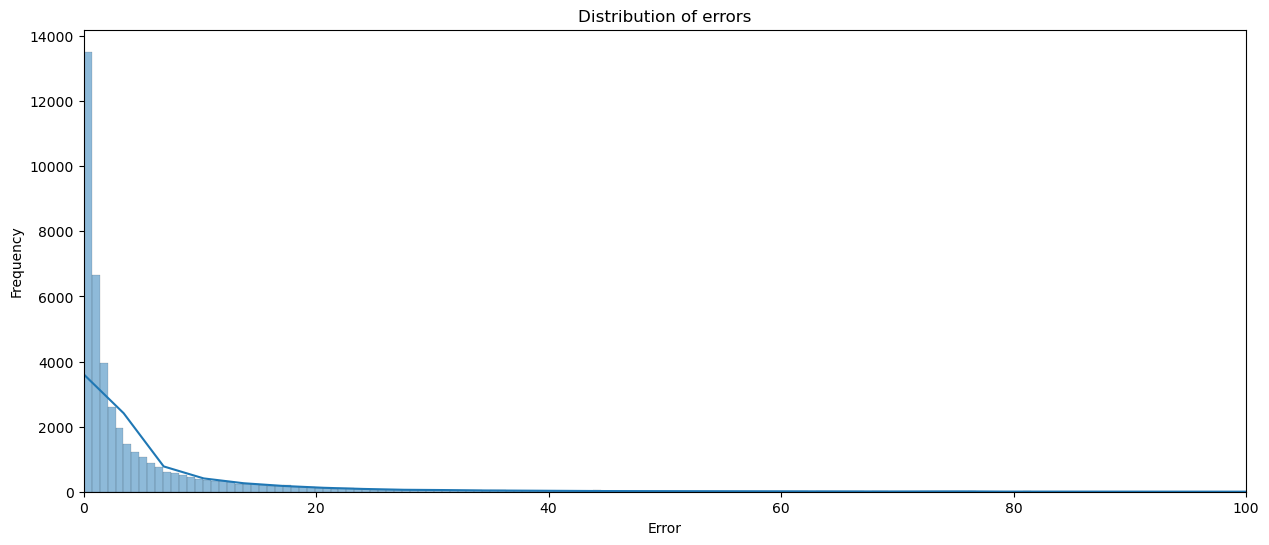

In [ ]:
# plot the distribution of errors with a histogram for errors less than 50
plt.figure(figsize=(15, 6))
sns.histplot(errors, bins=1000, kde=True)
plt.title('Distribution of errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()

In [ ]:
def compute_and_predict_depth_of_water(well_net, data, rf_model):
    for node in tqdm.tqdm(well_net.nodes, desc='Computing and predicting depth of water'):
        i = node
        if well_net.degree(i) > 0:
            well_net.nodes[i]['exp_depthofwater'] = 0
            total_weight = 0
            for neighbor in well_net.neighbors(i):
                j = neighbor
                weight = 1 / well_net.edges[i, j]['weight'] if well_net.edges[i, j]['weight'] > 0 else 0
                well_net.nodes[i]['exp_depthofwater'] += data['DepthToWater_m'][j] * weight
                total_weight += weight

            if total_weight > 0:
                well_net.nodes[i]['exp_depthofwater'] /= total_weight
        else:
            # Attributes for prediction
            X = data.iloc[i].values.reshape(1, -1)
            # Remove DepthToWater_m
            X = X[:, :-1]
            # Predict
            well_net.nodes[i]['exp_depthofwater'] = rf_model.predict(X)[0]

# Call the function
compute_and_predict_depth_of_water(well_net, data, rf_model)

Computing and predicting depth of water: 100%|██████████| 42626/42626 [00:57<00:00, 747.68it/s] 


In [73]:
import ee

# Authenticate to the Earth Engine servers
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize(project='morocco-ai-2024')

def get_soil_climate_data(well_coordinates):
    # inverse the coordinates
    well_coordinates = [well_coordinates[1], well_coordinates[0]]
    well_point = ee.Geometry.Point(well_coordinates)

    # Climate Data (Temperature and Precipitation)
    climate_data = ee.ImageCollection("OREGONSTATE/PRISM/AN81m") \
        .filterDate('2023-01-01', '2023-12-31') \
        .select(['tmean', 'ppt'])
    climate_clip = climate_data.mean().clip(well_point.buffer(1000))
    climate_stats = climate_clip.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=well_point,
        scale=1000
    )

    # Soil Data
    soil_ph_data = ee.Image("OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02")
    soil_ph_clip = soil_ph_data.clip(well_point.buffer(30))
    soil_ph_stats = soil_ph_clip.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=well_point,
        scale=30
    )

    soil_carbon_data = ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")
    soil_carbon_clip = soil_carbon_data.clip(well_point.buffer(30))
    soil_carbon_stats = soil_carbon_clip.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=well_point,
        scale=30
    )

    soil_sand_data = ee.Image("OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02")
    soil_sand_clip = soil_sand_data.clip(well_point.buffer(30))
    soil_sand_stats = soil_sand_clip.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=well_point,
        scale=30
    )

    soil_silt_data = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")
    soil_silt_clip = soil_silt_data.clip(well_point.buffer(30))
    soil_silt_stats = soil_silt_clip.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=well_point,
        scale=30
    )

    soil_clay_data = ee.Image("OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02")
    soil_clay_clip = soil_clay_data.clip(well_point.buffer(30))
    soil_clay_stats = soil_clay_clip.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=well_point,
        scale=30
    )

    combined_data = {
        "soil_ph": soil_ph_stats.getInfo(),
        "soil_carbon": soil_carbon_stats.getInfo(),
        "soil_sand": soil_sand_stats.getInfo(),
        "soil_silt": soil_silt_stats.getInfo(),
        "soil_clay": soil_clay_stats.getInfo(),
        "climate_conditions": climate_stats.getInfo(),
    }
    

    return combined_data

In [ ]:
from geopy.distance import geodesic
import numpy as np

def json_to_dataframe(json_data):
    # Flatten the JSON structure and format it for the final dataframe
    data = {}
    for key in json_data.keys():
        if isinstance(json_data[key], dict):
            sub_data = json_to_dataframe(json_data[key])
            for sub_key in sub_data.keys():
                data[f"{key}_{sub_key}"] = sub_data[sub_key]
        else:
            data[key] = json_data[key]
    return data

def compute_and_predict_depth_of_water(well_net, rf_model, new_location_coords, threshold_km=5):
    # Temporarily add the new location node to the graph
    well_net.add_node('new_node')
    
    # Get the latitude and longitude of the new location
    new_lat, new_lon = new_location_coords

    # Create temporary edges from the new node to nearby nodes based on the distance threshold
    for i in well_net.nodes:
        if i != 'new_node':  # Avoid connecting the node to itself
            # Get the coordinates of the existing node (Lat, Lon) from the graph attributes
            existing_lat = well_net.nodes[i]['Lat']
            existing_lon = well_net.nodes[i]['Lon']
            
            # Calculate the geodesic distance between the new node and the existing node
            distance = geodesic((new_lat, new_lon), (existing_lat, existing_lon)).kilometers
                        
            # If the distance is below the threshold, add an edge
            if distance < threshold_km:
                well_net.add_edge('new_node', i, weight=distance)
    
    # Initialize predicted depth
    predicted_depth = None
    
    # If the new node has neighbors, compute its expected water depth using the weighted sum method
    if well_net.degree('new_node') >0:
        print('Computing expected depth of water for the new location using the neighborhood convolution method...')
        total_weight = 0
        weighted_sum = 0
        
        for neighbor in well_net.neighbors('new_node'):
            weight = 1 / well_net.edges['new_node', neighbor]['weight'] if well_net.edges['new_node', neighbor]['weight'] > 0 else 0
            weighted_sum += well_net.nodes[neighbor]['DepthToWater_m'] * weight
            total_weight += weight
        
        if total_weight > 0:
            predicted_depth = weighted_sum / total_weight

    # If no neighbors, fall back to the Random Forest model
    else:
        print('No neighbors found for the new location. Using the Random Forest model for prediction...')
        # Fetch the extra soil and climate data for the new location using GEE API
        extra_data = get_soil_climate_data(new_location_coords)
        
        print(new_location_coords)
        
        # Flatten the fetched data into a dataframe-compatible format
        extra_data_flat = json_to_dataframe(extra_data)
        
        # Create the final feature vector for the new location
        combined_features = {
            'Lat': new_lat,
            'Lon': new_lon,
        }

        # Merge the soil and climate data into the combined features dictionary
        combined_features.update(extra_data_flat)

        # Convert the combined features to a DataFrame or appropriate structure for prediction
        combined_features_vector = np.array(list(combined_features.values())).reshape(1, -1)
        # add feature names
        features = ["soil_ph_b0", "soil_ph_b10", "soil_ph_b100", "soil_ph_b200", "soil_ph_b30", "soil_ph_b60", 
                    "soil_carbon_b0", "soil_carbon_b10", "soil_carbon_b100", "soil_carbon_b200", "soil_carbon_b30", "soil_carbon_b60", 
                    "soil_sand_b0", "soil_sand_b10", "soil_sand_b100", "soil_sand_b200", "soil_sand_b30", "soil_sand_b60", 
                    "soil_silt_b0", "soil_silt_b10", "soil_silt_b100", "soil_silt_b200", "soil_silt_b30", "soil_silt_b60", 
                    "soil_clay_b0", "soil_clay_b10", "soil_clay_b100", "soil_clay_b200", "soil_clay_b30", "soil_clay_b60", 
                    "climate_conditions_ppt", "climate_conditions_tmean", "Lat", "Lon"
                    ]
        combined_features_vector = pd.DataFrame(combined_features_vector, columns=features)
        # Use the combined feature vector to predict the depth using Random Forest
        predicted_depth = rf_model.predict(combined_features_vector)[0]

    # Remove the temporary node and edges from the graph
    well_net.remove_node('new_node')
    
    return predicted_depth

In [ ]:
# load rf model
import pickle

with open('bins/rf_depth_to_water.pkl', 'rb') as f:
    rf_model = pickle.load(f)

with open('bins/well_network.gpickle', 'rb') as f:
    well_net = pickle.load(f)

# # make a new location based on a node already in the graph to test the function for a node with neighbors
# # select all nodes with no neighbors
# nodes_neighbors = [node for node in well_net.nodes if well_net.degree(node) > 0]
# # randomly choose a node from the nodes with no neighbors
# node = np.random.choice(nodes_neighbors)

# make a new location based on a node not in the graph to test the function for a node without neighbors
# select all nodes with no neighbors
nodes_no_neighbors = [node for node in well_net.nodes if well_net.degree(node) == 0]
# randomly choose a node from the nodes with no neighbors
node = np.random.choice(nodes_no_neighbors)

new_location_coords = well_net.nodes[node]['Lat'], well_net.nodes[node]['Lon']

# Call the function to predict the depth of water at the new location
predicted_depth = compute_and_predict_depth_of_water(well_net, rf_model, new_location_coords)
print(f"Predicted Depth of Water at new location: {predicted_depth}")

No neighbors found for the new location. Using the Random Forest model for prediction...
(37.8992, -111.4388)
Predicted Depth of Water at new location: 48.357260200000034
